# ML_assignment3   NN error backpropogation
### In this problem, you need to build a neural network in order to classify images into three classes. Particularly, instead of calling on any existing functions in MATLAB or Python that do the tricks for you, you need to code on the error backpropagation algorithm by yourself in order to realize the learning process.

In [1]:
from __future__ import division

from PIL import Image
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

%matplotlib inline

# Load Data,  and use PCA to deduct dimension to 2

In [2]:
path = './Data_Train/Class'
def load_data():
    #class_one = np.array([]).reshape(0, 30, 30)
    class_all = list()
    target_all = list()
    for i in range(1, 4):
        class_path = path + str(i)
        for j in range (1, 1001):
            img_path = ''
            if(i == 1):
                img_path = class_path + '/faceTrain1_' + str(j) +'.bmp'
            elif(i == 2):
                img_path = class_path + '/faceTrain2_' + str(j) +'.bmp'
            elif(i == 3):
                img_path = class_path + '/faceTrain3_' + str(j) +'.bmp'
                
            im = Image.open(img_path)
            pixels = list(im.getdata())
            class_all.append(pixels)
            target_all.append((i-1))
            
    out = np.asarray(class_all)
    target_all = np.asarray(target_all)
    #target_all = np.expand_dims(target_all, axis=1)
    #print out_1.shape, out_2.shape, out_3.shape
    
    #Normalize
    mean_all =  out.mean(axis = 0)
    std_all = out.std(axis = 0)
    out = (out - mean_all) / std_all
    
    #PCA model
    pca = PCA(n_components=2)
    #Fit the model with X and apply the dimensionality reduction on data
    pca_all = pca.fit_transform(out) 
    
    #Shuffle
    np.random.seed(0)
    indices = np.arange(pca_all.shape[0])
    np.random.shuffle(indices)
    pca_all = pca_all[indices]
    target_all = target_all[indices]
    
    #Divide 90% for training and 10% for testing
    print 'pca_all data shape:', pca_all.shape
    print 'target_all:', target_all
    print 'target_all shape:', target_all.shape
    train_len = int(pca_all.shape[0]*0.9)
    return pca_all[:train_len], target_all[:train_len], pca_all[train_len:], target_all[train_len:]
            
train_data, train_target, test_data, test_target = load_data()

#Alaining bias
train_temp = np.zeros((train_data.shape[0], train_data.shape[1]+1))
train_temp[:, 0:train_data.shape[1]] = train_data
train_temp[:, train_data.shape[1]] = 1
train_data = train_temp

test_temp = np.zeros((test_data.shape[0], test_data.shape[1]+1))
test_temp[:, 0:test_data.shape[1]] = test_data
test_temp[:, test_data.shape[1]] = 1
test_data = test_temp
train_data

pca_all data shape: (3000, 2)
target_all: [0 1 1 ..., 1 2 2]
target_all shape: (3000,)


array([[ 19.81486755,  10.12537796,   1.        ],
       [-13.86012724,  -6.51638822,   1.        ],
       [ -7.20265163, -12.81298127,   1.        ],
       ..., 
       [  1.13687568, -13.39132635,   1.        ],
       [ -2.24199015,   7.87943923,   1.        ],
       [-12.46815591,  16.71987912,   1.        ]])

# Data distribution after PCA
### We can see that data from three different classes are seperated with each other.

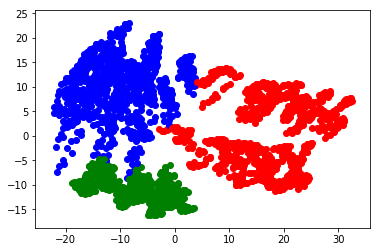

In [3]:
fig = plt.figure()
for i in range(0, 2700):
    #print train_target[i][0], ' ', train_data[i]
    if(train_target[i] == 0):
        plt.scatter(train_data[i][0], train_data[i][1], c='r', label='0')
    elif(train_target[i] == 1):
        plt.scatter(train_data[i][0], train_data[i][1], c='g', label='1')
    else:
        plt.scatter(train_data[i][0], train_data[i][1], c='b', label='2')
        
#plt.legend()
plt.show()


In [4]:
x = [[0,1,2], [2,3,4]]
print np.exp(x)
print np.sum(np.exp(x), axis = 1)
print np.sum(np.exp(x), axis = 1, keepdims=True)

[[  1.           2.71828183   7.3890561 ]
 [  7.3890561   20.08553692  54.59815003]]
[ 11.10733793  82.07274306]
[[ 11.10733793]
 [ 82.07274306]]


# Build two layer Neural Network

In [5]:
class NN_two_layer():
    def __init__(self, inputSize, hiddenSize, outputSize):
        self.w1 = np.random.rand(inputSize, hiddenSize)
        self.w2 = np.random.rand(hiddenSize, outputSize)
        
    def fully_connected(self, x, weight):
        return np.dot(x, weight)
    
    def sigmoid(self, x):
        return 1. / (1. + np.exp(-x))  
    
    def sigmoid_Prime(self, x):
        return x * (1.- x)
    
    def softmax(self, x):
        exp_x = np.exp(x)
        sum_exp_x = np.sum(exp_x, axis = 1, keepdims = True)
        return exp_x / sum_exp_x
    
    def cross_entropy(self, prediction, target):
        #loss = -tklog(pk)
        loss = 0
        num_data = prediction.shape[0]
        for i in range(0, num_data):
            loss += -1 * np.log(prediction[i][target[i]])
        return loss
    
    def cross_entropy_Prime(self, prediction, target):
        num_data = prediction.shape[0]
        grad = prediction
        grad[range(num_data), target] -= 1 # One hot
        return grad
                
    def forward(self, x):
        self.h1 = self.fully_connected(x, self.w1)
        self.a1 = self.sigmoid(self.h1)
        self.h2 = self.fully_connected(self.a1, self.w2)
        self.output = self.softmax(self.h2)
        return self.output
    
    def backward(self, x, output, target):
        learning_rate = 1e-3
        
        delta2 = self.cross_entropy_Prime(output, target)
        dw2 = (self.a1.T).dot(delta2)
        delta1 = delta2.dot(self.w2.T) * (self.sigmoid_Prime(self.a1))
        dw1 = np.dot(x.T, delta1)
        
        self.w1 -= learning_rate * dw1
        self.w2 -= learning_rate * dw2
        
    def train(self, train_data, train_target):
        output = self.forward(train_data)
        self.backward(train_data, output, train_target)
    
    def predict(self, x):
        output = self.forward(x)
        prediction = np.argmax(output, axis = 1)
        prediction = np.expand_dims(prediction, axis=1)
        return prediction
    
    
    

# Train the Model with 3000 epochs

In [6]:
model = NN_two_layer(inputSize=3, hiddenSize=5, outputSize=3)

train_iteration = 3000
for i in range(0, train_iteration):
    #model.train(train_data, train_target)
    output = model.forward(train_data)
    
    prediction = model.predict(train_data)
    loss = model.cross_entropy(output, train_target)
    train_accuracy = accuracy_score(prediction, train_target)
    
    model.backward(train_data, output, train_target)
    if(i % 200 == 0):
        if(i==0):
            print 'iteration:', i+1
        else:
            print 'iteration:', i
        print 'prediction', prediction.T
        print 'loss', loss
        print 'train_accuracy:', train_accuracy

iteration: 1
prediction [[1 1 1 ..., 0 1 1]]
loss 3472.85607252
train_accuracy: 0.337407407407
iteration: 200
prediction [[0 1 1 ..., 1 2 2]]
loss 138.855278198
train_accuracy: 0.987037037037
iteration: 400
prediction [[0 1 1 ..., 1 2 2]]
loss 104.369389341
train_accuracy: 0.98962962963
iteration: 600
prediction [[0 1 1 ..., 1 2 2]]
loss 95.1354027903
train_accuracy: 0.989259259259
iteration: 800
prediction [[0 1 1 ..., 1 2 2]]
loss 87.0499652541
train_accuracy: 0.991111111111
iteration: 1000
prediction [[0 1 1 ..., 1 2 2]]
loss 81.7571517082
train_accuracy: 0.991481481481
iteration: 1200
prediction [[0 1 1 ..., 1 2 2]]
loss 78.1345198821
train_accuracy: 0.991481481481
iteration: 1400
prediction [[0 1 1 ..., 1 2 2]]
loss 75.5458460702
train_accuracy: 0.991481481481
iteration: 1600
prediction [[0 1 1 ..., 1 2 2]]
loss 73.4753488947
train_accuracy: 0.991851851852
iteration: 1800
prediction [[0 1 1 ..., 1 2 2]]
loss 71.7310884124
train_accuracy: 0.991851851852
iteration: 2000
prediction [

# Testing

In [7]:
output = model.forward(test_data)
prediction = np.argmax(output, axis=1)
test_accuracy = accuracy_score(prediction, test_target)
print('test_accuracy', test_accuracy)

('test_accuracy', 0.98666666666666669)


# Draw Decision Boundary

(58504, 2)


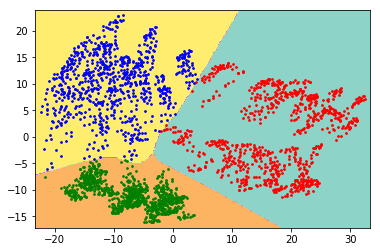

In [8]:
#Reference: http://scikit-learn.org/stable/auto_examples/linear_model/plot_sgd_iris.html
def decision_boundary(model, X):
    # create a mesh to plot in
    h = 0.2 #resolution
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    print(np.c_[xx.ravel(), yy.ravel()].shape)
    feature = np.c_[xx.ravel(), yy.ravel()]
    feature = np.concatenate((feature, np.ones((feature.shape[0], 1))), axis=1)
    Z = model.predict(feature)
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Set3)
    plt.axis('tight')
    
    #Plot also the training points
    prediction = model.predict(X)
    for i in range(0, X.shape[0]):
        if(prediction[i] == 0):
            plt.scatter(train_data[i][0], train_data[i][1], c='r', label='0', s=3)
        elif(prediction[i] == 1):
            plt.scatter(train_data[i][0], train_data[i][1], c='g', label='1', s=3)
        else:
            plt.scatter(train_data[i][0], train_data[i][1], c='b', label='2', s=3)

decision_boundary(model, train_data)


# Build three layer Neural Network

In [15]:
class NN_three_layer():
    def __init__(self, inputSize, h1_Size, h2_Size, outputSize, activation='sigmoid'):
        self.w1 = np.random.rand(inputSize, h1_Size)
        self.w2 = np.random.rand(h1_Size, h2_Size)
        self.w3 = np.random.rand(h2_Size, outputSize)
        self.activation = activation
        
    def fully_connected(self, x, weight):
        return np.dot(x, weight)
    
    def sigmoid(self, x):
        return 1. / (1. + np.exp(-x))  
    
    def sigmoid_Prime(self, x):
        return x * (1.- x)
    
    #######
    def relu(self, x):
        return np.maximum(0, x)
    
    def relu_Prime(self, x):
        return 1 * (x > 0)
    #######
    
    def softmax(self, x):
        exp_x = np.exp(x)
        sum_exp_x = np.sum(exp_x, axis = 1, keepdims = True)
        return exp_x / sum_exp_x
    
    def cross_entropy(self, prediction, target):
        #loss = -tklog(pk)
        loss = 0
        num_data = prediction.shape[0]
        for i in range(0, num_data):
            loss += -1 * np.log(prediction[i][target[i]])
        return loss
    
    def cross_entropy_Prime(self, prediction, target):
        num_data = prediction.shape[0]
        grad = prediction
        grad[range(num_data), target] -= 1 # One hot
        return grad
                
    def forward(self, x):
        if(self.activation == 'sigmoid'):
            self.h1 = self.fully_connected(x, self.w1)
            self.a1 = self.sigmoid(self.h1)
            self.h2 = self.fully_connected(self.a1, self.w2)
            self.a2 = self.sigmoid(self.h2)
            self.h3 = self.fully_connected(self.a2, self.w3)
            self.output = self.softmax(self.h3)
        elif(self.activation == 'relu'):
            self.h1 = self.fully_connected(x, self.w1)
            self.a1 = self.relu(self.h1)
            self.h2 = self.fully_connected(self.a1, self.w2)
            self.a2 = self.relu(self.h2)
            self.h3 = self.fully_connected(self.a2, self.w3)
            self.output = self.softmax(self.h3)
            
        return self.output
    
    def backward(self, x, output, target):
        learning_rate = 1e-3
        if(self.activation == 'sigmoid'):
            delta3 = self.cross_entropy_Prime(output, target)
            dw3 = (self.a2.T).dot(delta3)
            delta2 = delta3.dot(self.w3.T) * (self.sigmoid_Prime(self.a2))
            dw2 = (self.a1.T).dot(delta2)
            delta1 = delta2.dot(self.w2.T) * (self.sigmoid_Prime(self.a1))
            dw1 = np.dot(x.T, delta1)
        elif(self.activation == 'relu'):
            learning_rate = 1e-7
            delta3 = self.cross_entropy_Prime(output, target)
            dw3 = (self.a2.T).dot(delta3)
            delta2 = delta3.dot(self.w3.T) * (self.relu_Prime(self.h2))
            dw2 = (self.a1.T).dot(delta2)
            delta1 = delta2.dot(self.w2.T) * (self.relu_Prime(self.h1))
            dw1 = np.dot(x.T, delta1)
        
        self.w1 -= learning_rate * dw1
        self.w2 -= learning_rate * dw2
        self.w3 -= learning_rate * dw3
        
    def train(self, train_data, train_target):
        output = self.forward(train_data)
        self.backward(train_data, output, train_target)
    
    def predict(self, x):
        output = self.forward(x)
        prediction = np.argmax(output, axis = 1)
        prediction = np.expand_dims(prediction, axis=1)
        return prediction

# Train the model with 3000 epochs

In [16]:
model = NN_three_layer(inputSize=3, h1_Size=5, h2_Size=5, outputSize=3)

train_iteration = 3000
for i in range(0, train_iteration):
    #model.train(train_data, train_target)
    output = model.forward(train_data)
    
    prediction = model.predict(train_data)
    loss = model.cross_entropy(output, train_target)
    train_accuracy = accuracy_score(prediction, train_target)
    
    model.backward(train_data, output, train_target)
    if(i % 200 == 0):
        print('prediction', prediction.T)
        print('loss', loss)
        print('train_accuracy:', train_accuracy)

('prediction', array([[2, 2, 2, ..., 2, 2, 2]]))
('loss', 3144.9398162046177)
('train_accuracy:', 0.32962962962962961)
('prediction', array([[0, 1, 1, ..., 1, 2, 2]]))
('loss', 209.46096381251965)
('train_accuracy:', 0.98370370370370375)
('prediction', array([[0, 1, 1, ..., 1, 2, 2]]))
('loss', 122.1143098946601)
('train_accuracy:', 0.98888888888888893)
('prediction', array([[0, 1, 1, ..., 1, 2, 2]]))
('loss', 90.652466989059732)
('train_accuracy:', 0.99222222222222223)
('prediction', array([[0, 1, 1, ..., 1, 2, 2]]))
('loss', 77.070941052349013)
('train_accuracy:', 0.99222222222222223)
('prediction', array([[0, 1, 1, ..., 1, 2, 2]]))
('loss', 85.04447723661373)
('train_accuracy:', 0.99148148148148152)
('prediction', array([[0, 1, 1, ..., 1, 2, 2]]))
('loss', 94.880045705747918)
('train_accuracy:', 0.99037037037037035)
('prediction', array([[0, 1, 1, ..., 1, 2, 2]]))
('loss', 65.878580160315806)
('train_accuracy:', 0.99407407407407411)
('prediction', array([[0, 1, 1, ..., 1, 2, 2]]))
(

# Testing

In [17]:
output = model.forward(test_data)
prediction = np.argmax(output, axis=1)
test_accuracy = accuracy_score(prediction, test_target)
print('test_accuracy', test_accuracy)

('test_accuracy', 0.99333333333333329)


# Decision Boundary

(58504, 2)


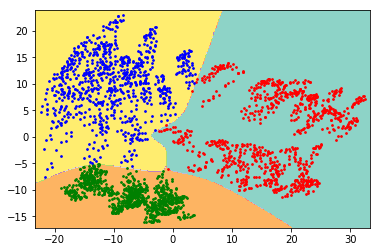

In [18]:
decision_boundary(model, train_data)

# Part C
### Because of my Normalization way (x = (x-mean) / std ), the results suffer gradient descent and get poor accuracy. I fixed the problem by employing another Normalization method(that rescaling to 0~1 version is in *.py files). Discussions are written in my report.

Training...
('prediction', array([[0, 0, 0, ..., 0, 0, 0]]))
('loss', 5127.5795029903766)
('train_accuracy:', 0.33703703703703702)
('prediction', array([[0, 0, 0, ..., 0, 2, 2]]))
('loss', 1577.336707679925)
('train_accuracy:', 0.63703703703703707)
('prediction', array([[0, 0, 0, ..., 0, 2, 2]]))
('loss', 1479.3924358757051)
('train_accuracy:', 0.63888888888888884)
('prediction', array([[0, 0, 0, ..., 0, 2, 2]]))
('loss', 1420.303322144581)
('train_accuracy:', 0.64111111111111108)
('prediction', array([[0, 0, 0, ..., 0, 2, 2]]))
('loss', 1377.9703661718074)
('train_accuracy:', 0.64222222222222225)
('prediction', array([[0, 0, 0, ..., 0, 2, 2]]))
('loss', 1345.1395232256953)
('train_accuracy:', 0.64370370370370367)
('prediction', array([[0, 0, 0, ..., 0, 2, 2]]))
('loss', 1318.4591452872573)
('train_accuracy:', 0.64444444444444449)
('prediction', array([[0, 0, 0, ..., 0, 2, 2]]))
('loss', 1296.3435325579428)
('train_accuracy:', 0.64518518518518519)
('prediction', array([[0, 0, 0, ..., 0

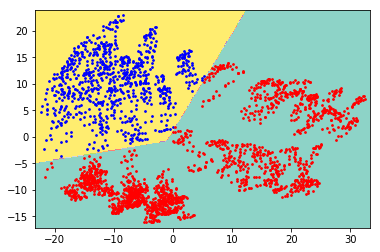

In [19]:
model = NN_three_layer(inputSize=3, h1_Size=5, h2_Size=5, outputSize=3, activation='relu')

train_iteration = 3000
print 'Training...'
for i in range(0, train_iteration):
    #model.train(train_data, train_target)
    output = model.forward(train_data)
    
    prediction = model.predict(train_data)
    loss = model.cross_entropy(output, train_target)
    train_accuracy = accuracy_score(prediction, train_target)
    
    model.backward(train_data, output, train_target)
    if(i % 200 == 0):
        print('prediction', prediction.T)
        print('loss', loss)
        print('train_accuracy:', train_accuracy)

print '\nTesting...'
output = model.forward(test_data)
prediction = np.argmax(output, axis=1)
test_accuracy = accuracy_score(prediction, test_target)
print('test_accuracy', test_accuracy)

decision_boundary(model, train_data)